In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import random 

from tqdm import tqdm 

In [10]:
class Rockne_FDM:

    dx: float
    dt: float
    lb: float

    s: callable
    alpha: float
    alpha_beta: float

    def __init__(self, l: int, tf: int, d: float, p: float, alpha: float, alpha_beta: float, size_dom: int):

        self.l = l
        self.tf = tf
        self.d = d
        self.p = p
        self.size_dom = size_dom

        x = np.linspace(0, 1, size_dom, dtype=np.float32)
        t = np.linspace(0, tf * p, tf, dtype=np.float32)

        self.dx = x[1]
        self.dt = t[1]
        self.lb = (d * self.dt) / (p * l**2 * self.dx**2)

        self.s = lambda d, a, ab: np.exp(-a * (d + (d**2 / ab)))
        self.alpha = alpha 
        self.alpha_beta = alpha_beta

    def MLQ(self, d: float) -> float:

        if d == 0: return -1 
        return -1 + (1 - self.s(d, self.alpha, self.alpha_beta)) / self.p

    def __call__(self, x: np.ndarray, d: float = -1.0) -> np.ndarray:

        a = np.zeros((self.size_dom, self.size_dom))
        b = np.zeros((self.size_dom, self.size_dom))
        gamma_a = 1. + 0.5 * self.dt * self.MLQ(d) + self.lb
        gamma_b = 1. - 0.5 * self.dt * self.MLQ(d) - self.lb

        a[0,0], a[-1, -1] = -3 / (4 * self.dx), 3 / (4 * self.dx)
        a[0,1], a[-1, -2] =  1 / (self.dx), -1 / (self.dx)
        a[0,2], a[-1, -3] = -1 / (4 * self.dx), 1 / (4 * self.dx)

        b[0,0], b[-1, -1] =  3 / (4 * self.dx), -3 / (4 * self.dx)
        b[0,1], b[-1, -2] = -1 / (self.dx), 1 / (self.dx)
        b[0,2], b[-1, -3] =  1 / (4 * self.dx), -1 / (4 * self.dx)

        for i in range(1, self.size_dom - 1):
            a[i,i], b[i,i] = gamma_a, gamma_b
            a[i,i+1], b[i,i+1] = -0.5 * self.lb, 0.5 * self.lb
            a[i,i-1], b[i,i-1] = -0.5 * self.lb, 0.5 * self.lb

        dir = b @ x
        esq = np.linalg.solve(a, dir)
        return esq
    
    def solve(self, condicao_inicial, protocolo):

        resultado = np.zeros((self.tf, self.size_dom))
        resultado[0] = condicao_inicial

        for i in tqdm(range(1, self.tf)): resultado[i] = self.__call__(resultado[i-1], protocolo[i-1])

        return resultado


In [11]:
def generate_protocol(dosagem_max: float, periodo: list, fracionamento: list, num_protocols: int, num_days: int, shuffler: bool = True):

    protocolos = []

    # Validação dos inputs
    if len(fracionamento) != len(periodo):
        raise ValueError("fracionamento e periodo devem ter o mesmo tamanho")
            
    # Verifica se dosagem_max é um intervalo ou valor único
    if isinstance(dosagem_max, list):
        if len(dosagem_max) != 2:
            raise ValueError("dosagem_max como lista deve ter exatamente 2 valores [min, max]")
        min_dose, max_dose = dosagem_max
    else:
        min_dose = max_dose = dosagem_max

    for num_frac, dias_trat in zip(fracionamento, periodo):
        if num_frac > dias_trat:
            raise ValueError("O número de frações não pode ser maior que o número de dias de tratamento.")
        if dias_trat > num_days:
            raise ValueError("O número total de dias de tratamento não pode exceder o tamanho do array.")
                
        for _ in range(num_protocols):
            # Gera uma dosagem máxima aleatória para este protocolo
            current_dosagem_max = random.uniform(min_dose, max_dose)
                    
            # Inicializa o array com zeros
            protocolo_array = [0] * num_days

            # Gerar os dias de administração (5 dias úteis, 2 de descanso)
            dias_fracoes = []
            for semana_inicio in range(1, dias_trat + 1, 7):
                dias_semana = list(range(semana_inicio, min(semana_inicio + 5, dias_trat + 1)))
                dias_fracoes.extend(dias_semana)

            # Selecionar dias aleatórios para as frações
            dias_selecionados = sorted(random.sample(dias_fracoes, min(num_frac, len(dias_fracoes))))

            # Gerar doses aleatórias
            doses = [
                round(random.uniform(0.1 * current_dosagem_max / num_frac, current_dosagem_max / num_frac), 2)
                for _ in range(num_frac)
            ]

            # Ajustar para soma exata da dosagem máxima
            fator_ajuste = current_dosagem_max / sum(doses)
            doses_ajustadas = [round(dose * fator_ajuste, 2) for dose in doses]

            # Preencher o protocolo
            for dia, dose in zip(dias_selecionados, doses_ajustadas):
                protocolo_array[dia - 1] = dose  # -1 para converter para índice zero-based

            protocolos.append(protocolo_array)

    # Converter para numpy array e embaralhar se necessário
    protocolos_array = np.array(protocolos, dtype=np.float32)
    if shuffler:
        np.random.shuffle(protocolos_array)

    return protocolos_array

In [12]:
# Parâmetros dos protocolos
dosagem_max = [45, 65]               # Gy
periodo = [2, 8, 21, 35, 49]        # dias
fracionamento = [2, 6, 15, 25, 35]  # quantidade de fracionamentos
quantidade_protocolos = 1000        # por fracionamento

protocolos = generate_protocol(dosagem_max, periodo, fracionamento, quantidade_protocolos, 80)
protocolos

array([[ 0.49,  1.18,  2.91, ...,  0.  ,  0.  ,  0.  ],
       [ 2.16,  1.5 ,  1.95, ...,  0.  ,  0.  ,  0.  ],
       [ 5.39,  4.95,  4.73, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 9.22, 10.  ,  8.2 , ...,  0.  ,  0.  ,  0.  ],
       [14.31,  8.98, 11.17, ...,  0.  ,  0.  ,  0.  ],
       [ 3.  ,  1.75,  2.21, ...,  0.  ,  0.  ,  0.  ]],
      shape=(5000, 80), dtype=float32)

In [24]:
# Parâmetros do modelo
d, p, alpha, alpha_beta = 0.0039, 0.0453, 3.05e-02, 10.

# Condição inicial
def c0(input, x0):

    f = lambda x: x0 * np.exp(-100 * x**2)
    return f(input)

condicao_inicial = c0(np.linspace(0, 1, 500), 8_000)


# Inicialização do modelo 
model = Rockne_FDM(20., 80, d, p, alpha, alpha_beta, len(condicao_inicial))


In [37]:
# Resolução do modelo

idx = 10
resultado = model.solve(condicao_inicial, protocolos[idx])

100%|██████████| 79/79 [00:00<00:00, 198.24it/s]


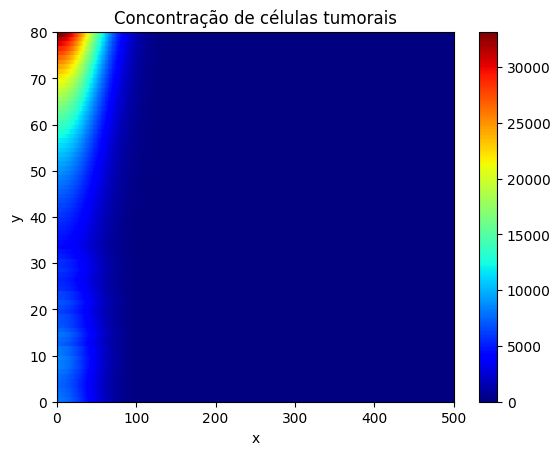

In [38]:
plt.pcolormesh(resultado.reshape(80, 500), cmap = 'jet')

plt.title('Concontração de células tumorais')
plt.xlabel('x')
plt.ylabel('y')

plt.colorbar()
plt.show()

In [39]:
# Função para calcular o raio tumoral
def calc_raio(result: np.ndarray, lenght: float, percent: float):

    t_size, x_size = result.shape
            
    dominio = np.linspace(0, lenght, x_size)

    raio = np.zeros((t_size))
    for i in range(t_size): raio[i] = np.max(np.where(result[i] >= percent, dominio / 20, 0))
    return raio

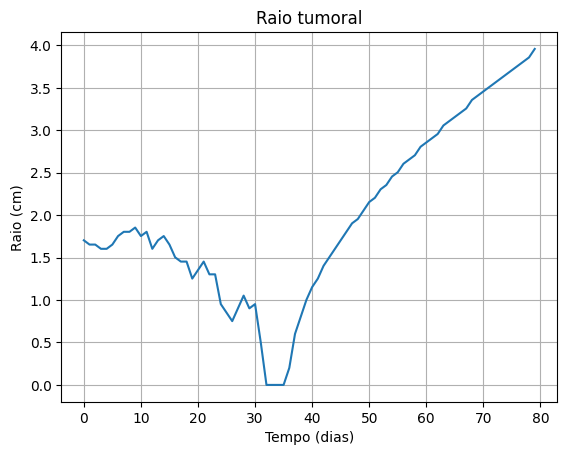

In [40]:
raio_tumoral = calc_raio(resultado, len(resultado[0]), 0.6127 * 8_000)

plt.plot(raio_tumoral)

plt.title('Raio tumoral')
plt.xlabel('Tempo (dias)')
plt.ylabel('Raio (cm)')

plt.grid()
plt.show()